In [3]:
# %load /Users/facai/Study/book_notes/preconfig.py
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font='SimHei', font_scale=2.5)
plt.rcParams['axes.grid'] = False

#import numpy as np

#import pandas as pd
#pd.options.display.max_rows = 20

#import sklearn

#import itertools

#import logging
#logger = logging.getLogger()

#from IPython.display import SVG
def show_image(filename, figsize=None, res_dir=True):
    if figsize:
        plt.figure(figsize=figsize)

    if res_dir:
        filename = './res/{}'.format(filename)

    plt.imshow(plt.imread(filename))

10 Sequence Modeling: Recurrent and Recursive Nets
==============

RNN: to process sequential data

traditionaly fully connected feedforward network: separate parameters at each position.
=> recurrent neural network: shares the same parameters across several steps.

### 10.1 Unfoliding Computational Graphs

recurrent neural networks: $h^{(t)} = f(h^{(t-1)}, x^{(t)}; \theta)$

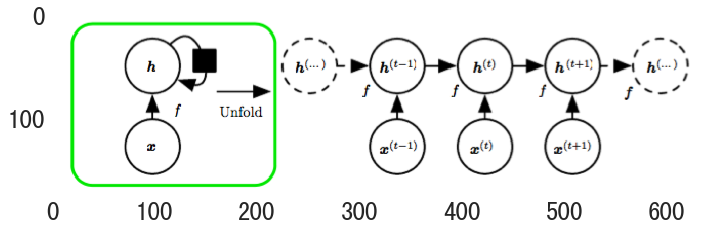

In [10]:
show_image('fig10_2.png', figsize=(12, 5))

two major advantages:
+ same input size even for a variable-length sequence.
+ use the **same** transition function $f$ with the same parameters at every time step.

unfolded graph: computing gradients

### 10.2 Recurrent Neural Networks

Different recurrent networks:

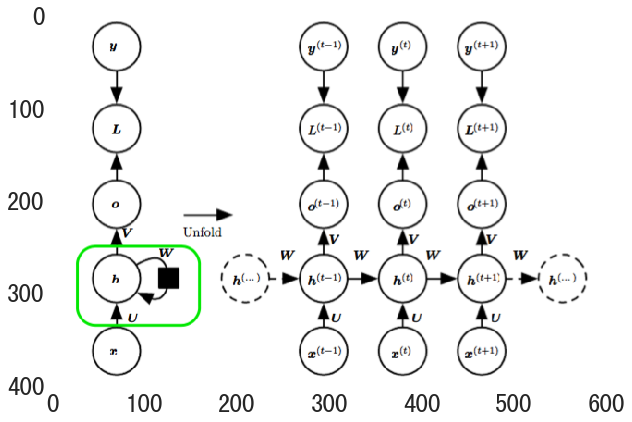

In [12]:
show_image('fig10_3.png', figsize=(10, 8))

\begin{equation}
    a^t = b + W h
\end{equation}